# Gene regulatory networks using chromatin accessibility

## Motivation

Analyzing chromatin accessibility and gene expression together to understand gene regulation is helpful due to the mechanistic relationship between those two during the control of gene regulation, mediated through transcription factors (TFs) and other epigenetic modulators {cite}`atac:Spitz2012-sw`. Briefly, regulatory regions annotated as promoters and local/distal enhancers are engaged during the early phases of gene expression regulation, and chromatin accessibility increase, or decrease, can be used as a proxy for changes in their activity. Hence, the global positive or negative correlation between proximal and distal accessible elements (measured by ATAC-seq) and target genes (measured by RNA-seq) within a genome neighborhood distance (e.g. less than 200 Kbp), serves to annotate genomic regulatory relationships during the inference of Gene Regulatory Networks (GRNs). Using sequencing data describing gene (RNA) and peak (ATAC) features, tools that build correlation matrices between peaks and matrices help summarize strong peak-gene interactions.

### Gene regulatory network inference using RNA and ATAC features

In this notebook, we will use the package **FigR** {cite}`atac:Kartha2022-lp` to describe such GRN-building steps on a donor of the NeurIPs dataset. Preparation scripts of this notebook will also call cisTopic {cite}`atac:Bravo_Gonzalez-Blas2019-zj` to generate peak clusters or **topics** from the ATAC seq counts matrix. During the calculation of RNA-ATAC correlations, FigR uses ChromVAR {cite}`atac:Schep2017-vi` to map Transcription Factor motifs to the mapped peaks. The main processing steps described in this notebook are adapted based on FigR's core tutorial for SHARE-seq data [Tutorial](https://buenrostrolab.github.io/FigR/articles/FigR_shareseq.html)

Disclaimer: At the time of writing this chapter, several methods that utilize single-cell RNA and ATAC information for GRN inference are currently available. Due to similar benchmarking reasons as the one indicated in the previous chapter, we cannot say that these methods will perform best in the majority of scenarios. We globally recommend either of those as a starting point, given available data, to infer preliminary GRNs.


### Install and load FigR package

In [ ]:
# the installation of this package is required for the proper execution of this notebook.
if(!suppressMessages(require("FigR"))){
    suppressMessages(devtools::install_github("caleblareau/BuenColors")) # the package BuenColors is also a devtools dependency to install FigR.
    suppressMessages(devtools::install_github("buenrostrolab/FigR"))
}

In [ ]:
suppressMessages(library(FigR))

### Use zellkonverter to convert h5ad to SingleCellExperiment

In [ ]:
library(zellkonverter)
library(SingleCellExperiment)

Load the full NeurIPs dataset using zellkonverter. Then, subset for one donor (s1d1) using the `batch` column. This donor will be the one used in this tutorial.

In [ ]:
sce <- readH5AD("../../data/openproblems_bmmc_multiome_genes_filtered.h5ad")
sce <- sce[colData(sce)$batch == 's1d1',]

For faster computing, we define a subset of features

In [ ]:
ncells = -1 # if using all cells
nfeatures_rna = 10000 # -1 if using all rna features
nfeatures_atac = 10000 # -1 if using all atac features

Once donor s1d1 is subset, divide features by RNA and ATAC into two objects
(in case of a new index, it can be checked with `rownames(sce)`)

In [ ]:
RNA <- sce[1:13431,]
ATAC <- sce[13432:nrow(sce),]

Download the list of TFs annotations for hg38, using the same gene labels as the RNA-only tutorial. Other annotations, such as [HumanTFs](http://humantfs.ccbr.utoronto.ca/), can also be used.

In [ ]:
if(!file.exists('allTFs_hg38.txt'))
    download.file('https://raw.githubusercontent.com/aertslab/SCENICprotocol/master/example/allTFs_hg38.txt', 'allTFs_hg38.txt')
tf_names = rownames(read.table('allTFs_hg38.txt', row.names=1))
print(length(tf_names))

[1] 1797


In [ ]:
# subset by cells:
if(ncells != -1){
    RNA <- RNA[,1:ncells]
    ATAC <- ATAC[,1:ncells]
}
if(nfeatures_rna != -1){

    # select all TFs and a subset of non-TFs
    is_tf <- rownames(RNA) %in% tf_names
    index_tf <- which(is_tf)
    index_not_tf <- which(!is_tf)
    set.seed(nfeatures_rna)
    RNA <- RNA[c(index_tf, sample(index_not_tf, nfeatures_rna - length(index_tf))),]
}


Selection of peaks, based on the coefficient of variation criterion, adapted from the [EpiScanpy's implementation](https://episcanpy.readthedocs.io/en/anna/api/episcanpy.pp.select_var_feature.html)

In [ ]:
if(nfeatures_atac != -1){
    frac_atac <- rowSums(assay(ATAC)) / ncol(ATAC)
    acc_score <- abs(0.5 - frac_atac)
    peak_mask <- rownames(ATAC) %in% names(sort(acc_score))[1:nfeatures_atac]
    ATAC <- ATAC[peak_mask,]
}


In [ ]:
print(c(dim(ATAC), dim(RNA)))
is_tf <- rownames(RNA) %in% tf_names

[1] 10000  6224 10000  6224


In [ ]:
UMAP <- reducedDim(ATAC, 'GEX_X_umap')

In [ ]:
# counts variable (for later functions)
assay(ATAC) <- as(assay(ATAC), 'sparseMatrix')
counts(ATAC) <- assay(ATAC)

Preprocessing of SummarizedExperimentObject using the number of cells

In [ ]:
# Remove genes with zero expression across all cells
# RNA <- RNA[Matrix::rowSums(RNA) != 0,]

### Preparation and execution of cisTopic

cisTopic applies Latent Dirichlet allocation to define a number of "topics" that are able to summarize the variability of the observed chromatin accessibility counts retrieved by ATAC-seq. Here, we install, calculate of the cisTopic object using scATAC-seq, and use it downstream as input for FigR.

Installation of cisTopic through devtools (if required). This installation takes approximately ten minutes, due to cisTopic-specific dependencies.
(restart of kernel might be required)

In [ ]:
if(!suppressMessages(require("cisTopic")))
    suppressMessages(devtools::install_github("aertslab/cisTopic"))

In [ ]:
suppressMessages(library(cisTopic))

The following script requires indicating a number of cores (`nCores`). Increase according to computing resources available

In [ ]:
nCores = 2

In [ ]:
cistopic_bkp_path <- "../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_cisTopic.rds"
if(nfeatures_atac != -1)
    cistopic_bkp_path <- paste0("../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_cisTopic_npeaks", nfeatures_atac, ".rds")
print(c(file.exists(cistopic_bkp_path), cistopic_bkp_path))

[1] "TRUE"                                                                                          
[2] "../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_cisTopic_npeaks10000.rds"


This analysis through cisTopic allows us to retrieve and interpret two specific values, as line plots:
- A curve showing the main log-likelihood calculated by cisTopic, versus the number of topics. A plateau of this curve number indicates that additional topics are not main factors to explain the data, versus previous topics.
- The first derivative of likelihood versus number of declared topics. This visualization is useful to assess convergence in the likelihood value, and random oscillations around zero, as the number of topics increases.

[1] "Formatting data..."
[1] "Exporting data..."
[1] "Running models..."


Loading required package: umap



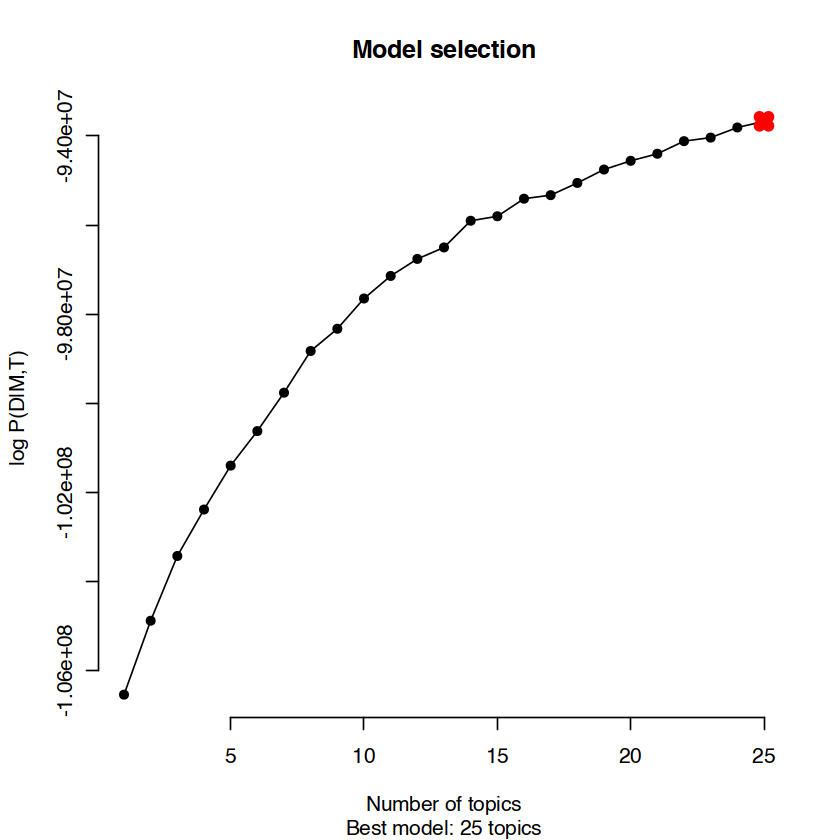

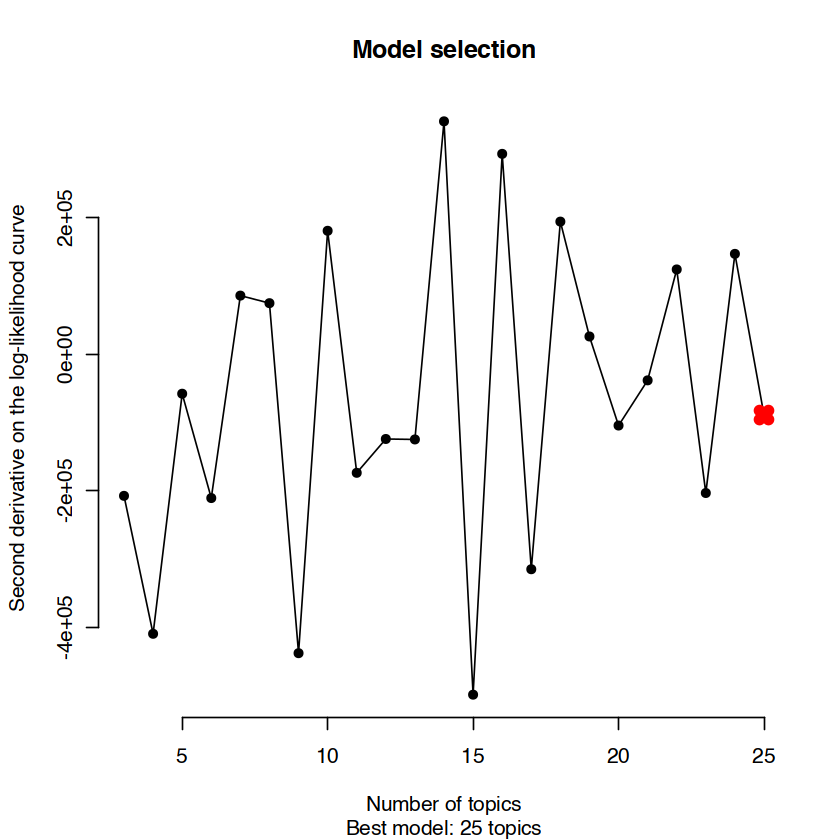

In [ ]:
overwrite = TRUE # to visualize plots, this will always execute. Modify to FALSE to avoid replacing output from previous runs.
if(!file.exists(cistopic_bkp_path) || overwrite){
    # the number of topics to test
    n_topics = 1:25

    atac <- as.matrix(counts(ATAC))
    atac <- as.data.frame(atac)

    # we need to work out the names of the rownames, and replace - into : to match the chromosome:start-end required format by cisTopic
    chr <- sapply(strsplit(rownames(atac),"-"), `[`, 1)
    start <- sapply(strsplit(rownames(atac),"-"), `[`, 2)
    end <- sapply(strsplit(rownames(atac),"-"), `[`, 3)
    rownames(atac) <- paste0(chr, ':', start, '-', end)

    cisTopicObject <- createcisTopicObject(atac, project.name='neurips_s1d1')
    cisTopicObject <- runCGSModels(cisTopicObject, topic=c(n_topics), # , 5:15, 20, 25), # topic=c(2, 5:15, 20, 25),
                               seed=987, nCores=nCores, burnin = 90,
                               iterations = 100, addModels=FALSE)

    cisTopicObject <- selectModel(cisTopicObject, type='maximum')

    # cisTopicObject
    cisTopicObject <- runUmap(cisTopicObject, target='cell')

    topic.mat <- modelMatSelection(cisTopicObject, 'cell', 'Probability')
    topic.mat <- t(topic.mat)
    topic.mat <- as.matrix(topic.mat)
    saveRDS(topic.mat, cistopic_bkp_path)
}

Once the CisTopic object is generated, we can use it to extract relevant features

In [ ]:
cisAssign <- readRDS(cistopic_bkp_path)
dim(cisAssign) # Cells x Topics

[1] 6224   25

Calculate a kNN-graph using the topics matrix from cisTopic

In [ ]:
library(dplyr)
library(FNN)

In [ ]:
set.seed(123)
cellkNN <- get.knn(cisAssign, k = 30)$nn.index
dim(cellkNN)

[1] 6224   30

Visualization of cells using the embedding generated by UMAP

In [ ]:
colData(ATAC)$cellAnnot <- colData(ATAC)$cell_type

In [ ]:
colData(ATAC)$UMAP1 <- UMAP[,1]
colData(ATAC)$UMAP2 <- UMAP[,2]

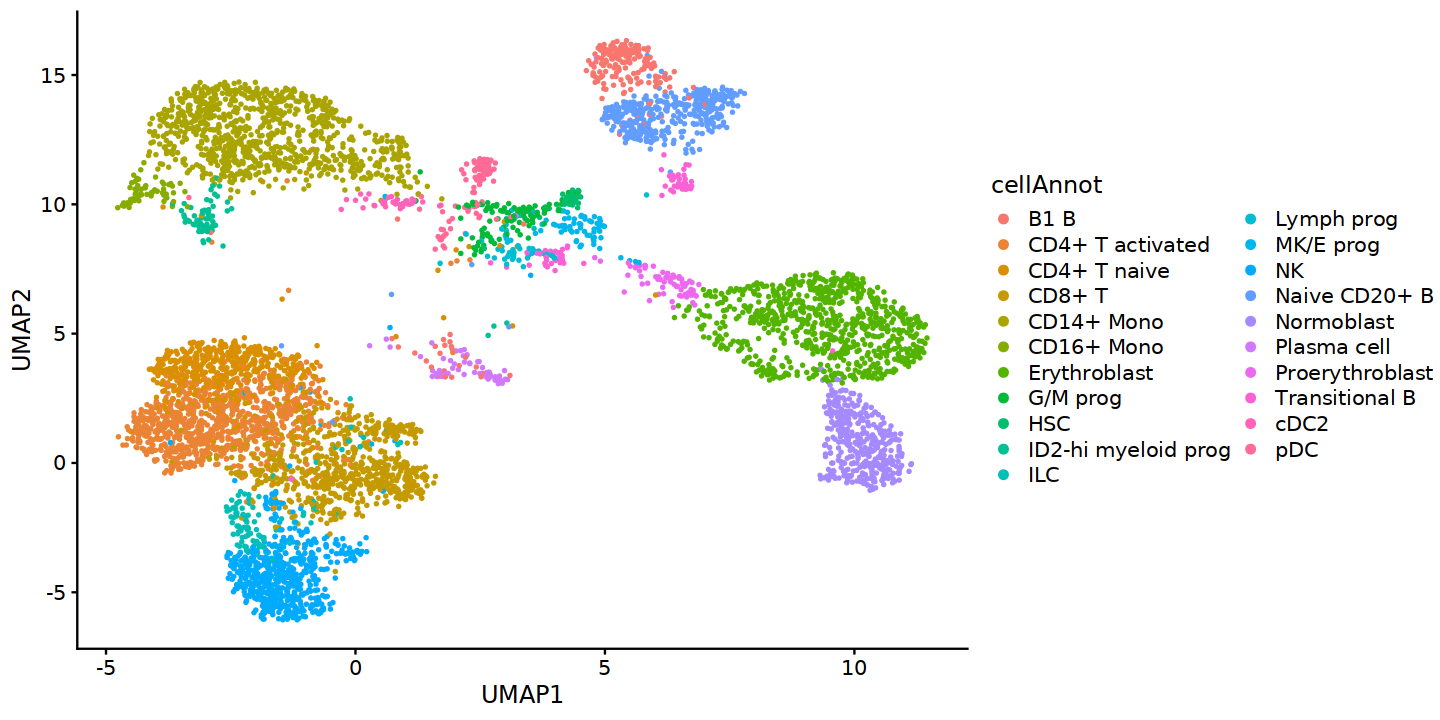

In [ ]:
# Plot
library(ggplot2)
options(repr.plot.width=12, repr.plot.height=6)
colData(ATAC) %>% as.data.frame() %>% ggplot(aes(UMAP1,UMAP2,color=cellAnnot)) +
  geom_point(size=0.5) + # scale_color_manual(values=annoCols)+
  theme_classic() + guides(colour = guide_legend(override.aes = list(size=2))) + cowplot::theme_cowplot(font_family='Sans')

Preparation of input data is finished. Now, the execution of the FigR algorithm begins.

In [ ]:
# if the hg38 genome is not installed successfully during environment building, it can be installed here.
# this might require a kernel restart
if(!suppressMessages(require('BSgenome.Hsapiens.UCSC.hg38'))){
    if (!require("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
    BiocManager::install("BSgenome.Hsapiens.UCSC.hg38")
}

In [ ]:
suppressMessages(library(BSgenome.Hsapiens.UCSC.hg38))

In [ ]:
# check object dimensions
c(dim(ATAC), dim(RNA))

[1] 10000  6224 10000  6224

The following script requires indicating a number of cores (`nCores`). Increase according to computing resources available

Prepare data for runGenePeakcorr

In [ ]:
library(Matrix)
RNAmat <- as.matrix(assay(RNA))
dim(RNAmat)

[1] 10000  6224

In [ ]:
ATAC_df <- as.data.frame(as.matrix(counts(ATAC)))
# df <- as.data.frame(as.matrix(counts(ATAC)))

In [ ]:
ATAC_df$seqnames <- sapply(strsplit(rownames(ATAC_df),"-"), `[`, 1)
ATAC_df$start <- sapply(strsplit(rownames(ATAC_df),"-"), `[`, 2)
ATAC_df$end <- sapply(strsplit(rownames(ATAC_df),"-"), `[`, 3)

In [ ]:
ATAC_df <- subset(ATAC_df, grepl('chr', rownames(ATAC_df)))
dim(ATAC_df)

[1] 9997 6227

In [ ]:
ATAC.se <- makeSummarizedExperimentFromDataFrame(ATAC_df)
counts(ATAC.se) <- assay(ATAC.se)
assay(ATAC.se) <- as(assay(ATAC.se), 'sparseMatrix')

Run runGenePeakcorr function from FigR using 2 cores

In [ ]:
# This snippet can be run interactively, but it takes a long time.
nCores = 2
bkp_path_ciscorr <- '../../data/openproblems_bmmc_multiome_genes_filtered_s1d1_ciscorr.rds'
if(nfeatures_atac != -1)
    cistopic_bkp_path <- paste0("../../data/openproblems_bmmc_multiome_genes_filtered_s1d1_ciscorr_npeaks", nfeatures_atac, ".rds")

if(!file.exists(bkp_path_ciscorr)){
    cisCorr <- FigR::runGenePeakcorr(ATAC.se = ATAC.se,
                               RNAmat = RNAmat,
                               genome = "hg38", # One of hg19, mm10 or hg38
                               nCores = nCores,
                               p.cut = NULL, # Set this to NULL and we can filter later
                               n_bg = 250)
    saveRDS(cisCorr, bkp_path_ciscorr)
}
cisCorr <- readRDS(bkp_path_ciscorr)

Filter relevant peak-gene correlations by p-value

In [ ]:
cisCorr.filt <- cisCorr %>% filter(pvalZ <= 0.05)
print(c('all associations', nrow(cisCorr)))
print(c('filtered associations', nrow(cisCorr.filt)))

[1] "all associations" "3914"            
[1] "filtered associations" "674"                  


In [ ]:
if(nrow(cisCorr.filt) == 0)
    print('increase the number of cells/peaks/genes to discover more associations')
stopifnot(nrow(cisCorr.filt) > 0)

Once the Peak and Gene correlations have been calculated, FigR groups ATAC-seq peaks into Domains of regulatory chromatin (DORCs). These groups are useful to describe relationships between the expression of TFs RNA levels with the overall change of multiple chromatin-accessible elements around a gene. Importantly, if multiple of those chromatin-accessible elements in a DORC also contain DNA-binding motifs related to the TF of interest, both lines of evidence are useful for broadly describing TF activators (TF motif enrichment and positive DORC - TF RNA correlation) or TF repressors (TF motif enrichment and negative DORC - TF RNA correlation).

The visualization below indicates the ranking of TFs by the number of peaks strongly correlated to those and provides information about which TFs are most strongly associated with DORCs.

In [ ]:
library(ggrepel)

NULL

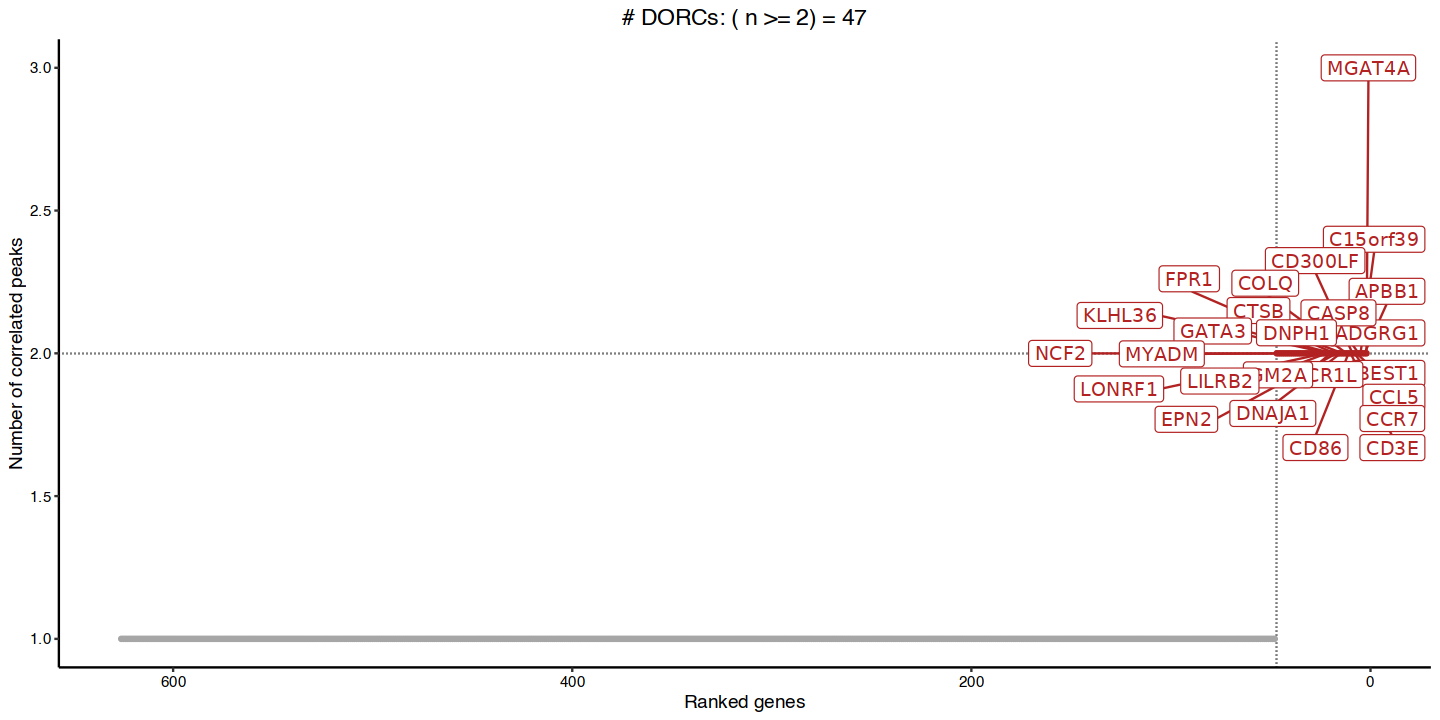

In [ ]:
# Determine DORC genes
options(repr.plot.width=12, repr.plot.height=6)
cowplot_mono <- cowplot::theme_cowplot(font_family='sans')
dorcGenes <- cisCorr.filt %>% dorcJPlot(cutoff=2, # Default
                                       returnGeneList = TRUE, family='sans') # + cowplot_mono

theme_set(theme_gray(base_family = "sans"))
dorcGenes + theme(font='roboto') # font problem during visualization of y/x axes (Roboto)

Modify the cutoff here to recover at last 30 genes. Otherwise, the runFigRGRN could not be executed.

In [ ]:
stopifnot(length(dorcGenes) > 30)

Get DORC scores

In [ ]:
dorcMat <- getDORCScores(ATAC.se, dorcTab=cisCorr.filt, geneList=dorcGenes, nCores=nCores)
# Smooth DORC scores (using cell KNNs)

Running DORC scoring for 47 genes: MGAT4A
ADGRG1
APBB1
BEST1
C15orf39
CASP8
CCL5
CCR7
CD300LF
CD3E
CD86
COLQ
CR1L
CTSB
DNAJA1
DNPH1
EPN2
FPR1
GATA3
GM2A
KLHL36
LILRB2
LONRF1
MYADM
NCF2
NFIA
NOLC1
P2RX1
PRF1
PRKCQ-AS1
PTCH1
RFPL1S
RHOQ
RXRA
SESN3
SLC16A6
SLC2A9
SMAD7
STRN3
SWAP70
TEC
THEMIS
TLE1
TM9SF2
TNRC6B
ZNF471
ZNRF1



........
Normalizing scATAC counts ..
SummarizedExperiment object input detected .. Centering counts under assayCentering counts for cells sequentially in groups of size  5000  ..

Computing centered counts for cells:  1  to  5000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  5001  to  6224 ..
Computing centered counts per cell using mean reads in features ..

Merging results..
Done!
Computing DORC scores ..
Running in parallel using  2 cores ..

Time Elapsed:  0.89201807975769 secs 



In [ ]:
stopifnot(nrow(cellkNN) == ncol(dorcMat))

In [ ]:
rownames(cellkNN) <- colnames(dorcMat)

To execute the smoothScores NN function with multiple cores, doParallel is required.

In [ ]:
library(doParallel)

In [ ]:
# Smooth dorc scores using cell KNNs (k=30)
dorcMat.s <- smoothScoresNN(NNmat = cellkNN[,1:30], mat = dorcMat, nCores = nCores)

Number of cells in supplied matrix:  6224 
Number of genes in supplied matrix:  47 
Number of nearest neighbors being used per cell for smoothing:  30 
  |                                                                      |   0%Running in parallel using  2 cores ..
  |======================================================================| 100%
Merging results ..

Time Elapsed:  14.4018683433533 secs 


In [ ]:
stopifnot(nrow(cellkNN) == ncol(RNAmat))

In [ ]:
rownames(cellkNN) <- colnames(RNAmat)

In [ ]:
# Smooth RNA using cell KNNs
# This takes longer since it's all genes
RNAmat.s <- smoothScoresNN(NNmat = cellkNN[,1:30], mat = RNAmat, nCores = nCores)

Number of cells in supplied matrix:  6224 
Number of genes in supplied matrix:  10000 
Number of nearest neighbors being used per cell for smoothing:  30 
  |                                                                      |   0%Running in parallel using  2 cores ..
  |======================================================================| 100%
Merging results ..

Time Elapsed:  1.23741063674291 mins 


In [ ]:
library(ggplot2)
library(ggrastr)

In [ ]:
# Visualize on pre-computed UMAP
umap.d <- as.data.frame(colData(ATAC)[,c("UMAP1","UMAP2")])

Once the DORC scores are calculated, we can explore associations between TFs and target genes, or the overall expression of TFs in each of cell types. Those two metrics contribute to an understanding of how cell types.

In [ ]:
print(length(dorcGenes))
print(dorcGenes)

[1] 47
 [1] "MGAT4A"    "ADGRG1"    "APBB1"     "BEST1"     "C15orf39"  "CASP8"    
 [7] "CCL5"      "CCR7"      "CD300LF"   "CD3E"      "CD86"      "COLQ"     
[13] "CR1L"      "CTSB"      "DNAJA1"    "DNPH1"     "EPN2"      "FPR1"     
[19] "GATA3"     "GM2A"      "KLHL36"    "LILRB2"    "LONRF1"    "MYADM"    
[25] "NCF2"      "NFIA"      "NOLC1"     "P2RX1"     "PRF1"      "PRKCQ-AS1"
[31] "PTCH1"     "RFPL1S"    "RHOQ"      "RXRA"      "SESN3"     "SLC16A6"  
[37] "SLC2A9"    "SMAD7"     "STRN3"     "SWAP70"    "TEC"       "THEMIS"   
[43] "TLE1"      "TM9SF2"    "TNRC6B"    "ZNF471"    "ZNRF1"    


One of the genes with strong correlations with TF expression is [Nuclear Factor I A (NFIA)](http://humantfs.ccbr.utoronto.ca/myTFPageUniversal.php?user=&eID=ENSG00000162599&dbd=&submit_param=submit_value). We can inspect this case further by checking its gene expression levels and dorcGenes linked with its motif on ATAC peaks.

In [ ]:
marker_gene = 'NFIA'

In [ ]:
dorcg <- plotMarker2D(umap.d,dorcMat.s,markers = c(marker_gene),maxCutoff = "q0.99",
                      colorPalette = "brewer_heat") + ggtitle(paste0(marker_gene, ' DORC'))


Plotting  NFIA 


In [ ]:
rnag <- plotMarker2D(umap.d,RNAmat.s,markers = c(marker_gene),maxCutoff = "q0.99",
                     colorPalette = "brewer_purple") + ggtitle(paste0(marker_gene, ' RNA'))

Plotting  NFIA 


Here, we visualize dorcg and rnag objects, using patchwork. This allows visual comparison of gene expression and associated DORC scores, per cell.

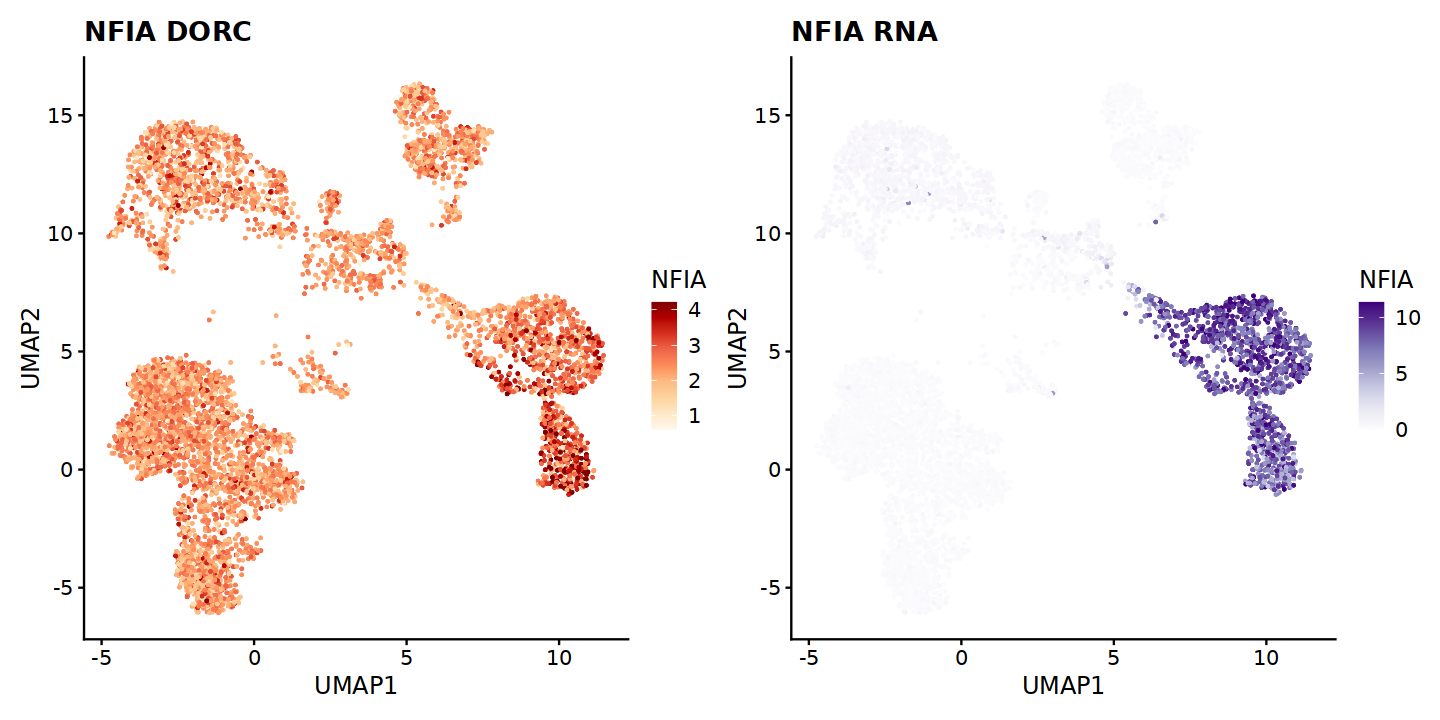

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)
library(patchwork)
dorcg + cowplot_mono + rnag + cowplot_mono

Through a visual comparison, we can identify that the agreement between NFIA expression and DORC scores is not 1-to-1, meaning that in some cell type clusters NFIA is strongly expressed, yet there is no strong correlation between those expression levels and ATAC peaks putatively occupied with NFIA.

In [ ]:
dim(dorcMat.s)

[1]   47 6224

In [ ]:
figR.d <- runFigRGRN(ATAC.se = ATAC.se, # Must be the same input as used in runGenePeakcorr()
                     dorcTab = cisCorr.filt, # Filtered peak-gene associations
                     genome = "hg38",
                     dorcMat = dorcMat.s,
                     rnaMat = RNAmat.s,
                     nCores = nCores)

Assuming peak indices in Peak field

Removing genes with 0 expression across cells ..




Getting peak x motif matches ..
Determining background peaks ..
Using  50  iterations ..

Testing  626  TFs
Testing  47  DORCs


Running FigR using 2 cores ..




  |======================================================================| 100%Finished!
Merging results ..


## Results visualization

TF-DORC regulation scores (scatter plot). The y-axis indicates motif enrichment of a TF in DORCs, whereas the x-axis indicates the correlation between TF expression and those peaks (Z-test versus background). Intuitively, this visualization allows us to retrieve putative TF-activators (upper-right) and TF-repressors (upper-left).

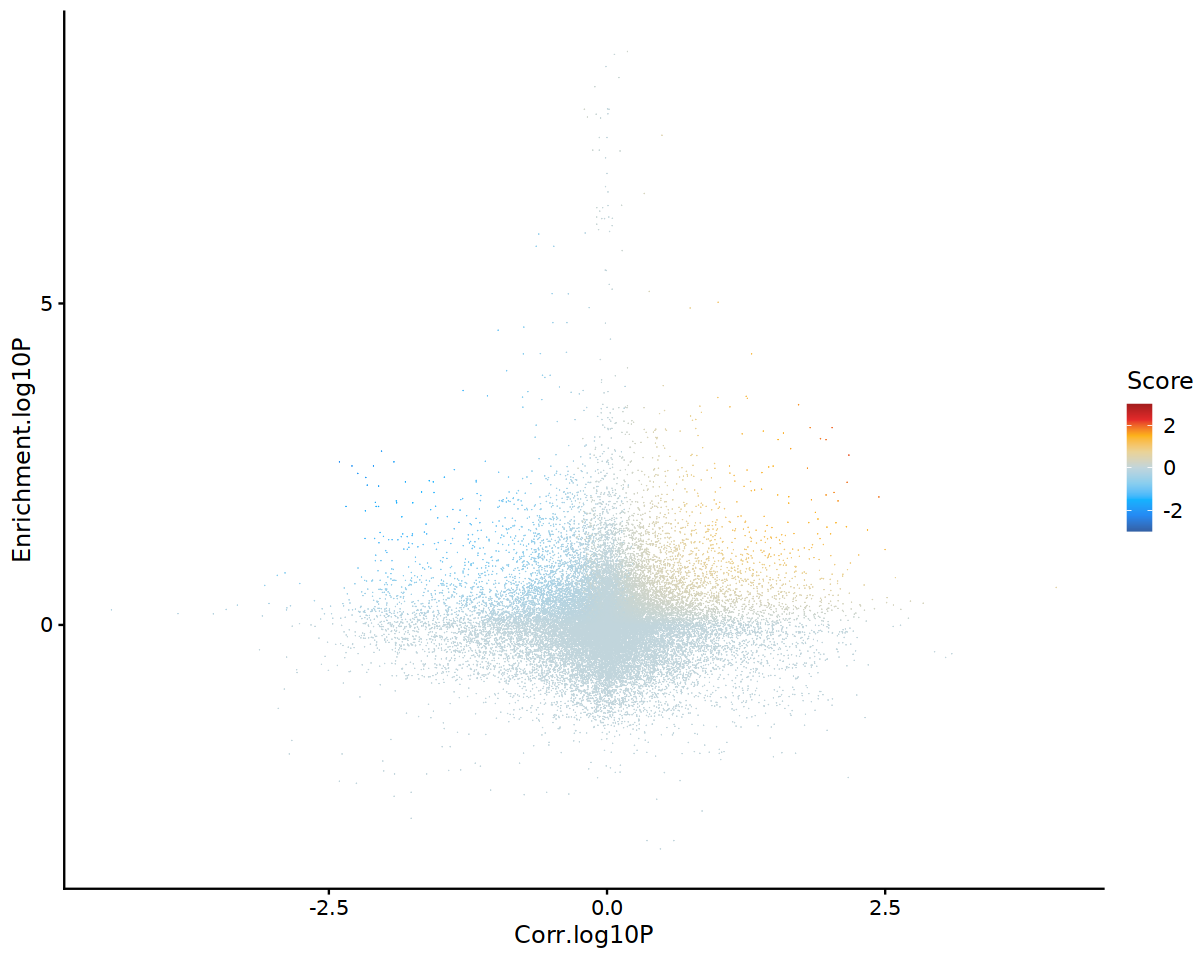

In [ ]:
require(ggplot2)
require(ggrastr)
require(BuenColors) # https://github.com/caleblareau/BuenColors

options(repr.plot.width=10, repr.plot.height=8)

figR.d %>%
  ggplot(aes(Corr.log10P,Enrichment.log10P,color=Score)) +
  ggrastr::geom_point_rast(size=0.01,shape=16) +
  theme_classic() +
  scale_color_gradientn(colours = jdb_palette("solar_extra"),limits=c(-3,3),oob = scales::squish,breaks=scales::breaks_pretty(n=3)) +
  cowplot_mono + cowplot::theme_cowplot(font_family='sans' )

Rank based visualization of driver TFs, to get an intuitive positive-negative priority list of relevant TF candidates.

Ranking TFs by mean regulation score across all DORCs ..


Warning message:
“ggrepel: 39 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 51 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 55 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


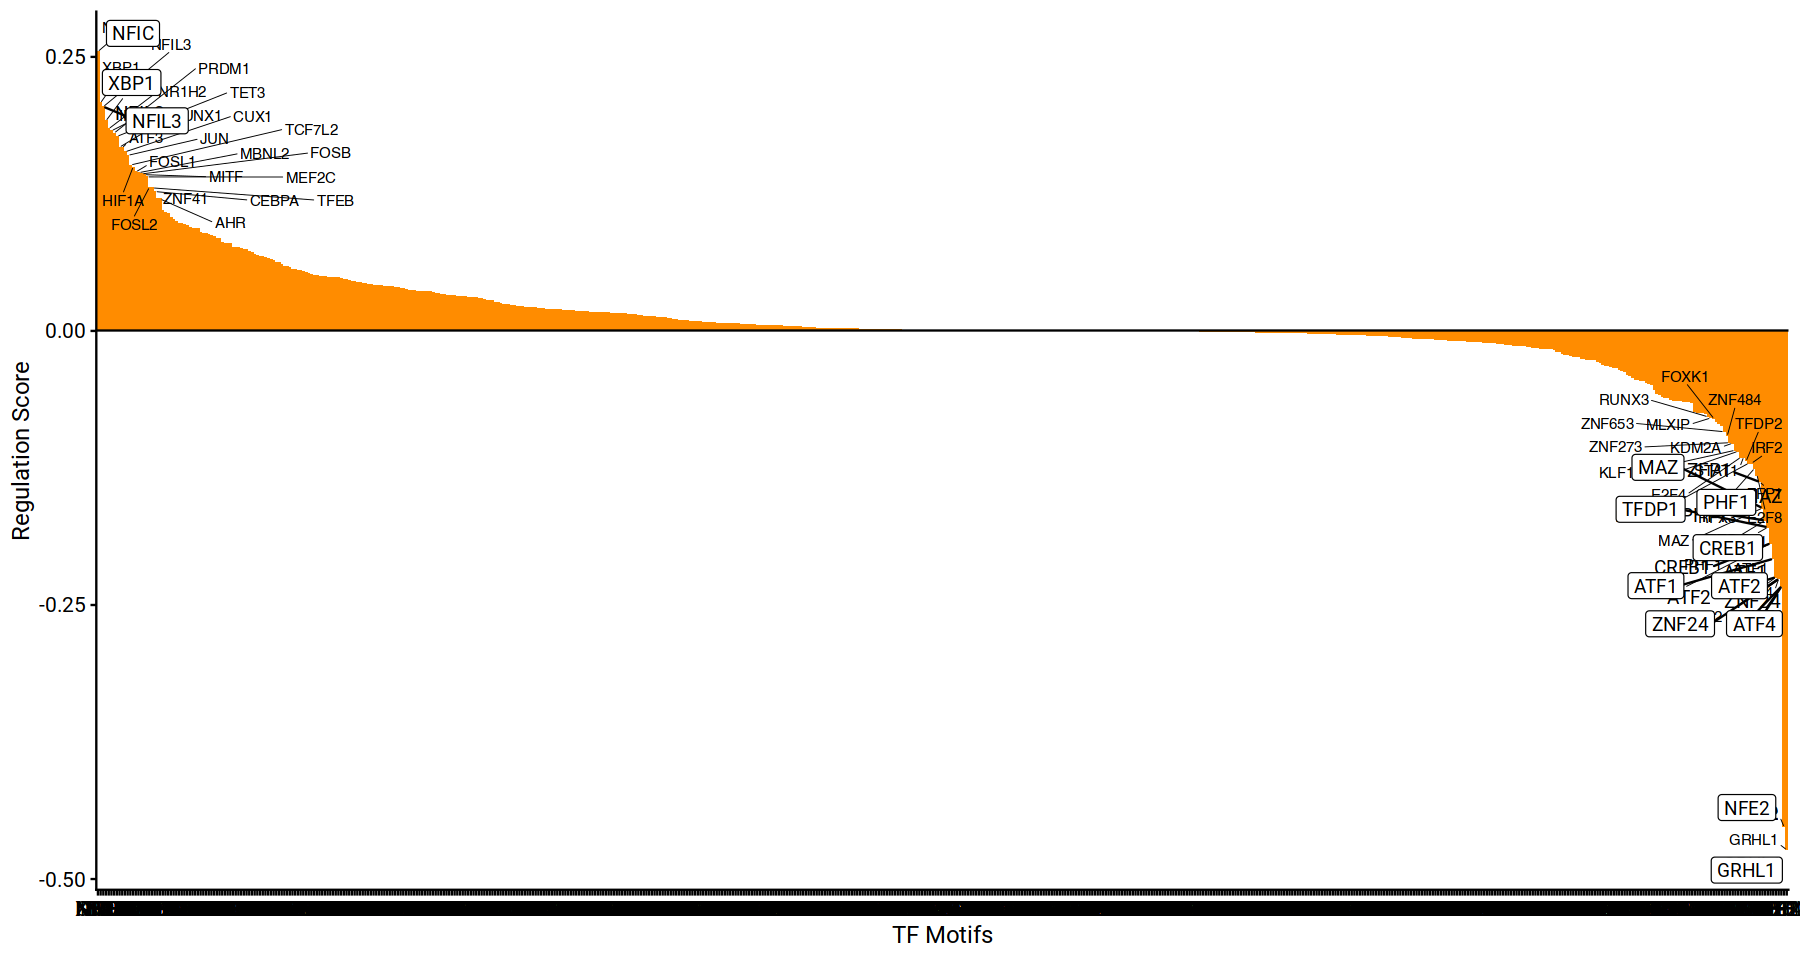

In [ ]:
drivers <- rankDrivers(figR.d, rankBy = "meanScore",interactive = FALSE)
options(repr.plot.width=15, repr.plot.height=8)
drivers + geom_text_repel(family='roboto') + geom_label_repel(family='roboto') + cowplot::theme_cowplot(font_family='roboto') + labs(font_family='roboto')

This next visualization attempts to visualize the relevant motifs annotated, by their associated number of target genes activated or repressed. This allows to observe the coverage of top-motifs potentially activating or repressing certain gene programs in the studied sample.


Ranking TFs by total number of associated DORCs ..


Using absolute score cut-off of: 1 ..




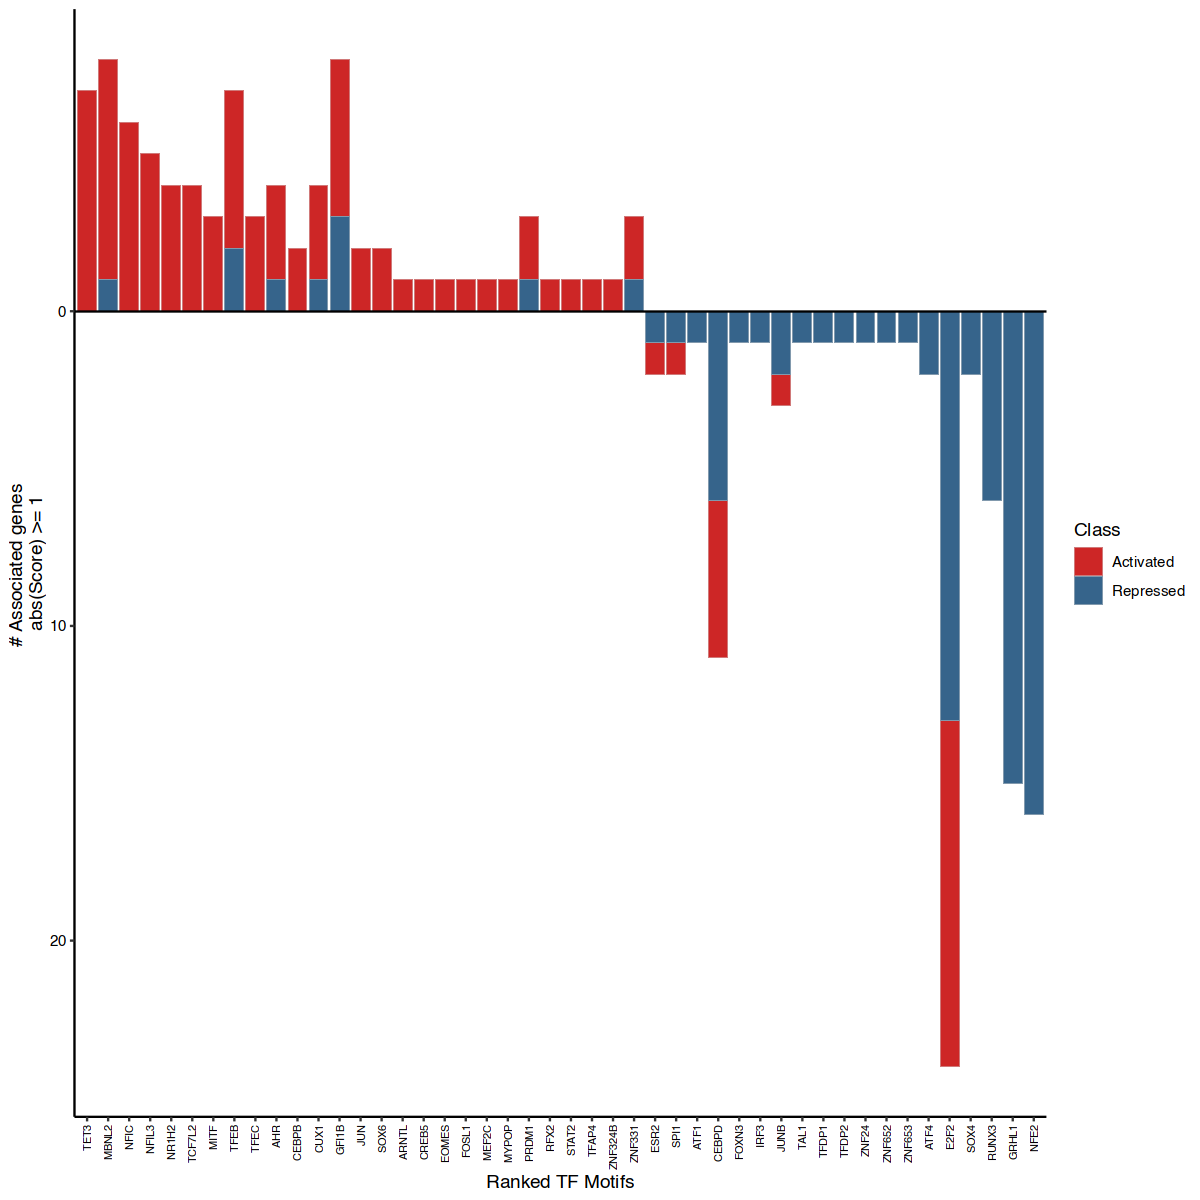

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
rankDrivers(figR.d,score.cut = 1, rankBy = "nTargets", interactive = FALSE, fontsiz)

The following visualization is a heatmap-based visualization of DORC-scores for candidate TFs and strong genes they potentially regulate, based on TF-DORC-target gene associations.
(Rows = Target genes, Columns = TF).

In [ ]:
library(grid)
library(ComplexHeatmap)

Using absolute score cut-off of: 1 ..


Using Score as value column: use value.var to override.

Plotting 45 DORCs x 46TFs




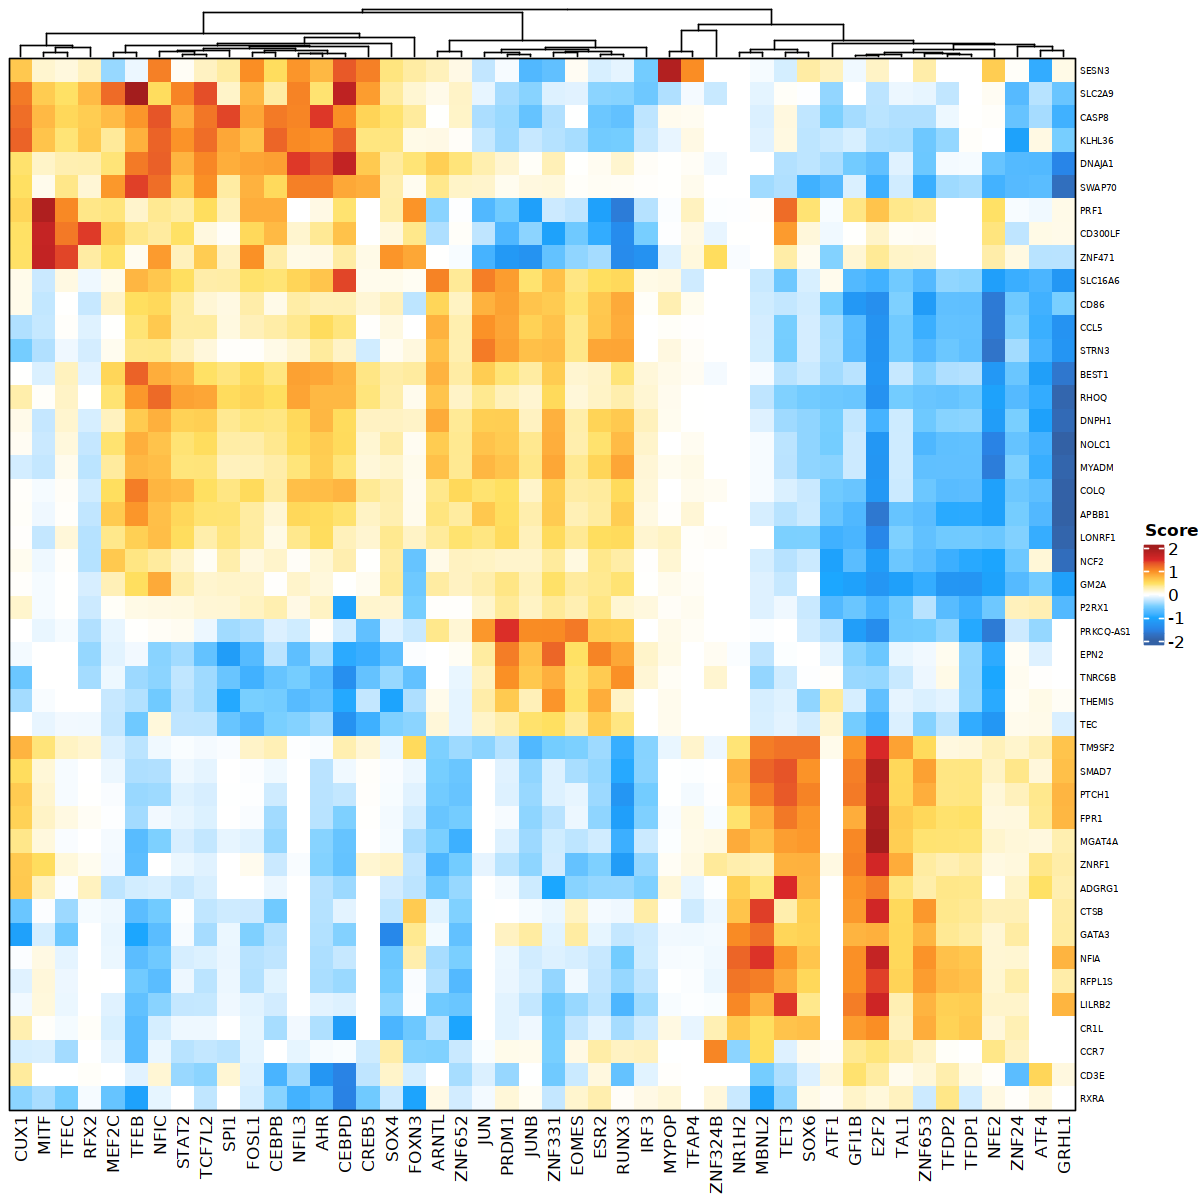

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)
pushViewport(viewport(gp = gpar(fontfamily = "sans")));
heatmap <- plotfigRHeatmap(figR.d = figR.d,
                           score.cut = 1,
                           TFs = unique(figR.d$Motif),
                           column_names_gp = gpar(fontsize=10), # from ComplexHeatmap
                           show_row_dend = FALSE # from ComplexHeatmap
                          )
draw(heatmap, newpage = FALSE)
popViewport()


This visualization allows us to quickly identify the main TFs and their association with the regulation of potential target genes through DORCs in their genome neighborhoods.

As a last exploratory visualization, a network of associations can also be retrieved, using the package networkD3. This allows exploring clusters of genes that are overlapping across TFs, and potentially overlapping regulons controlled by common-TFs.

In [ ]:
library(networkD3)
library(r2d3)
library(imager)

In [ ]:
# generate the network
d3 <- plotfigRNetwork(figR.d,
                      score.cut = 1,
                      TFs = unique(figR.d$Motif),
                      weight.edges = TRUE)

In [ ]:
# in a local session, the network can be manipulated interactively
d3

HTML widgets cannot be represented in plain text (need html)

### Save network as HTML/PNG

In [ ]:
# If pandoc if not found by R, here the bin path in the environment has to be provided e.g. `envs/best_practices_regulons_rnanatac/bin`
# rmarkdown::find_pandoc(dir = "bin_path") # e.g. bin_path = '~/miniconda3/envs/best_practices_regulons_rnanatac/bin'

# is saved as an image and shown for exploratory purposes outside of this notebook
save_d3_html(
  d3,
  'network_tutorial_rna_n_atac.html',
)

In [ ]:
# the network is saved as an image and shown for online purposes.
save_d3_png(
  d3,
  'network_tutorial_rna_n_atac.png',
  width = 350,
  height = 450,
  delay = 4.0,
  zoom = 1.6,
)

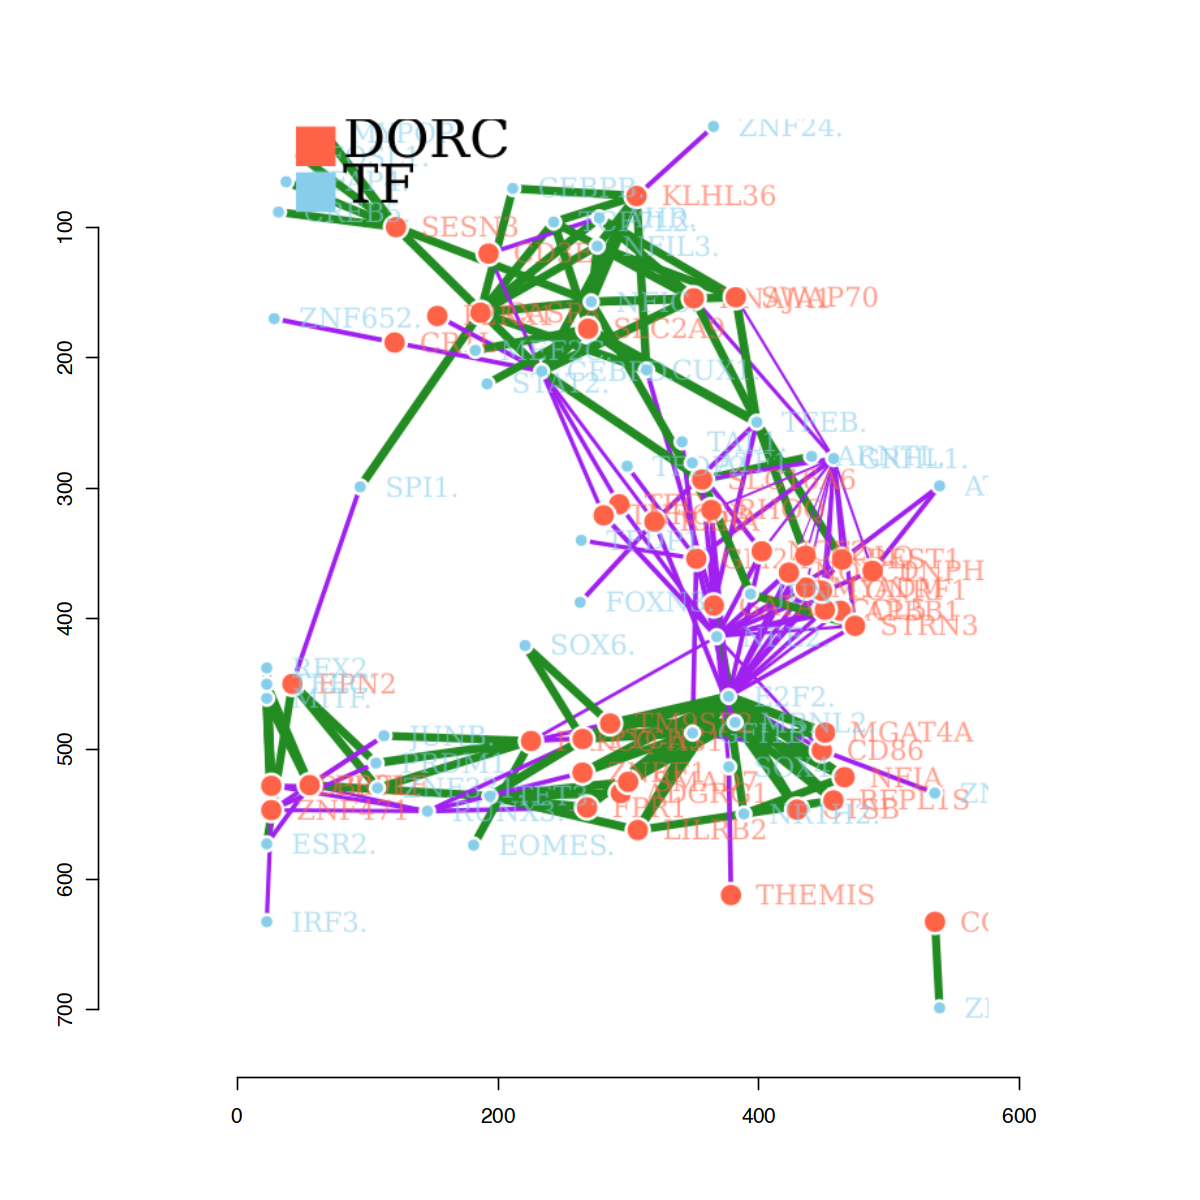

In [ ]:
im <- load.image('network_tutorial_rna_atac.png')
plot(im)

Log of packages used to execute this notebook

In [ ]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04 LTS

Matrix products: default
BLAS/LAPACK: /home/rio/miniconda3/envs/best_practices_regulons_rnanatac/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] imager_0.42.19                    magrittr_2.0.3                   
 [3] r2d3_0.2.6                        networkD3_0.4                    
 [5] ComplexHeatmap_2.14.0             BuenColors_0.5.6                 
 [7] MASS_7.3-58.3                     patchwork_1.1.2                  
 [9] ggrastr_

## Takeaways

In this notebook, we have:

1. Prepared an RNA and ATAC object using R, for processing with FigR and CisTopic.
2. Calculated DORC scores with FigR, and visualized those as scatter, heatmap and networks.

## Quiz

### Theory

In [ ]:
%run ../src/lib.py

flip_card("q1", "Why are peak-to-gene associations considered mechanistically valid?", "Peak-to-gene associations are considered mechanistically valid because they link accessible chromatin regions (peaks) to their target genes, reflecting the physical interactions where regulatory elements influence gene expression.", back_font_size=15)
flip_card("q2", "Are there generally more chromatin peaks than genes when processing ATAC and RNA data? What is the consequence at the level of structure, when building GRNs?", "sGenerally, there are more chromatin peaks than genes in ATAC-seq data, leading to a many-to-one relationship in gene regulatory networks (GRNs) where multiple regulatory elements can control a single gene.", front_font_size=15, back_font_size=15)
flip_card("q3", "What is considered a TF activatior/repressor at the level of chromatin accessibility, and at the level of gene regulation?", "At the level of chromatin accessibility, transcription factor (TF) activators increase accessibility by promoting an open chromatin state, while repressors decrease accessibility by inducing a closed state; in terms of gene regulation, activators enhance transcription, whereas repressors inhibit it.", back_font_size=13)
flip_card("q4", "Which additional readouts are complementary to scRNA-seq and scATAC-seq, when interpreting ATAC+RNA GRN models?", "Complementary readouts to scRNA-seq and scATAC-seq include techniques like ChIP-seq for profiling protein-DNA interactions and Hi-C for capturing chromatin conformation, providing additional layers of regulatory information.", back_font_size=15)

### FigR

In [2]:
flip_card("q1", "What is the DORC score and how it could be useful to identify regulatory interactions between peaks and genes?", "The DORC (Domain of Regulatory Chromatin) score quantifies the aggregate accessibility of multiple chromatin peaks associated with a single gene, aiding in identifying regulatory interactions by correlating these accessibility domains with gene expression levels.", back_font_size=15)

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: atac
```

## Contributors
We gratefully acknowledge the contributions of:
### Authors
* Ignacio Ibarra
### Reviewers
* Lukas Heumos
* Anna Schaar